# MultiVI: Integrative clustering of scRNA + scATAC (PBMC example)


This notebook demonstrates how to: download a preprocessed PBMC multiome dataset, train a MultiVI model (scvi-tools), extract a joint latent space, visualize with UMAP, run Leiden clustering, and impute missing gene expression for ATAC-only cells.


All cells below include a short plain-language explanation of what the following code does.

In [ ]:
# Colab: install scvi-tools environment helper (runs pip installs)
!pip install --quiet scvi-colab


# `scvi_colab.install()` installs/sets up the correct versions for Colab
from scvi_colab import install
install()


# After running this cell: if Colab prompts you to restart the runtime, please do so.

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.12/dist-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.


In [ ]:
# Standard imports used in scvi-tools tutorials
import os
import tempfile
import requests


import muon as mu
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch


# Set random seed for reproducibility (scvi settings)
scvi.settings.seed = 0
print("scvi-tools version:", scvi.__version__)


# Optional plotting defaults
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()

/usr/local/lib/python3.12/dist-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/dist-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/dist-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/usr/local/lib/python3.12/dist-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape sequence '\s'
  .. math:: Q = \sum_k \\lambda_k Q_k.
INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


scvi-tools version: 1.4.0


In [ ]:
# Create a temporary folder to store the downloaded file
save_dir = tempfile.TemporaryDirectory()
mdata_path = os.path.join(save_dir.name, "pbmc_10k_preprocessed.h5mu")


# Figshare direct download URL used in the official tutorial
url = "https://figshare.com/ndownloader/files/54794234"


if not os.path.exists(mdata_path):
  print(f"Downloading MuData file to {mdata_path}...")
  r = requests.get(url)
  with open(mdata_path, "wb") as f:
    f.write(r.content)


# Load the MuData object
mdata = mu.read_h5mu(mdata_path)


# Quick summary
print(mdata)

MuData object with n_obs × n_vars = 12012 × 8000
  var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
  2 modalities
    rna_subset:	12012 x 4000
      var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'
    atac_subset:	12012 x 4000
      var:	'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'hvg'


/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
# Register the modalities inside the MuData object for MULTIVI
scvi.model.MULTIVI.setup_mudata(
mdata,
modalities={
"rna_layer": "rna_subset",
"atac_layer": "atac_subset",
},
)


# Create the MultiVI model object (specify how many genes and peaks the model will expect)
model = scvi.model.MULTIVI(
mdata,
n_genes=len(mdata.mod["rna_subset"].var),
n_regions=len(mdata.mod["atac_subset"].var),
)


# View the anndata setup summary (what scvi-tools registered and where it expects input)
model.view_anndata_setup()

/usr/local/lib/python3.12/dist-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 1.4.0.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'rna_layer': None,
│   'atac_layer': None,
│   'protein_layer': None,
│   'batch_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None,
│   'idx_layer': None,
│   'modalities': {'rna_layer': 'rna_subset', 'atac_layer': 'atac_subset'}
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_atac          │ 4000  │
│         n_batch          │   1   │
│         n_cells          │ 12012 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│      n_size_factor       │   0   │
│          n_vars          │ 4000  │
└──────────────────────────┴───────┘

                Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location     ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.mod['rna_subset'].X  │
│     atac     │ adata.mod['atac_subset'].X │
│    batch     │  adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']    │
│    labels    │ adata.obs['_scvi_labels']  │
└──────────────┴────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
# Convert to CSR (training is faster with CSR for sparse matrices)
mdata.mod["rna_subset"].X = mdata.mod["rna_subset"].X.tocsr()
mdata.mod["atac_subset"].X = mdata.mod["atac_subset"].X.tocsr()


# Propagate changes
mdata.update()


# Optional: quick look at obs / var
print(mdata.obs.head())
print(mdata.mod["rna_subset"].var.shape, mdata.mod["atac_subset"].var.shape)

                    _indices  _scvi_batch  _scvi_labels
AAACAGCCAAAGCCTC-1         0            0             0
AAACAGCCAGAATGAC-1         1            0             0
AAACAGCCAGCTACGT-1         2            0             0
AAACAGCCAGGCCTTG-1         3            0             0
AAACAGCCATAAGGAC-1         4            0             0
(4000, 7) (4000, 7)


/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
# Train the model. You can pass max_epochs to shorten/lengthen training.
# If you are on Colab, enabling GPU in the runtime will speed this up.
model.train()

/usr/local/lib/python3.12/dist-packages/scvi/model/_multivi.py:333: UserWarning: Disabling adversarial classifier.
  training_plan = self._training_plan_cls(self.module, **plan_kwargs)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:527: Found 158 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 927.854. Signaling Trainer to stop.


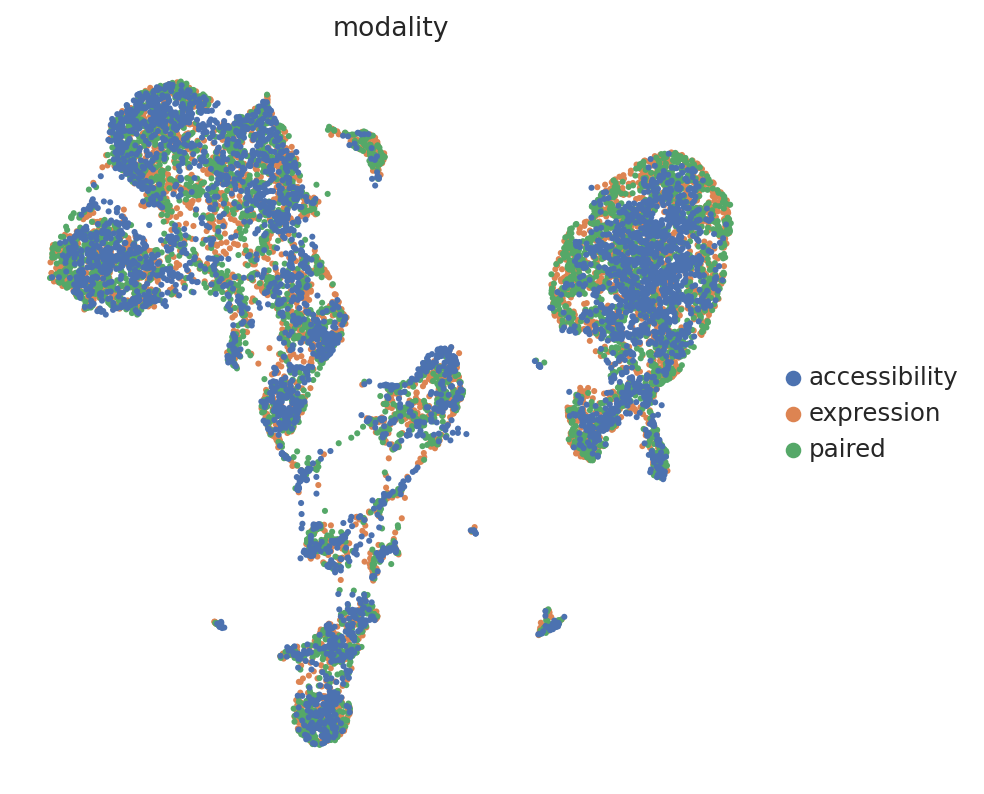

In [ ]:
# Key name for the latent embedding
MULTIVI_LATENT_KEY = "X_multivi"


# Store the latent representation in mdata.obsm
mdata.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()


# Build the neighbor graph and compute UMAP using the MultiVI latent embedding
sc.pp.neighbors(mdata, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(mdata, min_dist=0.2)


# Create a simple modality annotation column (this dataset was split by the tutorial to contain
# some RNA-only, some paired, some ATAC-only cells so we can test imputation)
n = mdata.n_obs // 3
mdata.obs["modality"] = ""
mdata.obs.iloc[:n, mdata.obs.columns.get_loc("modality")] = "expression"
mdata.obs.iloc[n:2*n, mdata.obs.columns.get_loc("modality")] = "paired"
mdata.obs.iloc[2*n:, mdata.obs.columns.get_loc("modality")] = "accessibility"


# Plot UMAP colored by modality
sc.pl.umap(mdata, color="modality", size=30)

/tmp/ipython-input-3813170259.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata, resolution=1.0, key_added="leiden_multivi")


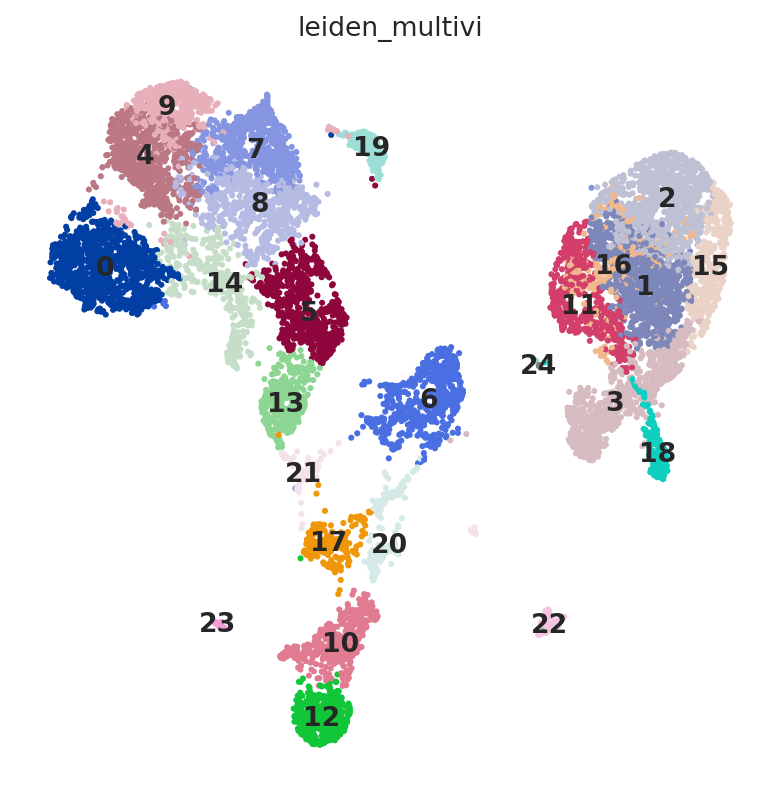

In [ ]:
# Run Leiden clustering — results are stored in mdata.obs['leiden']
sc.tl.leiden(mdata, resolution=1.0, key_added="leiden_multivi")


# Plot clusters
sc.pl.umap(mdata, color="leiden_multivi", legend_loc="on data", size=30)

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:461: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

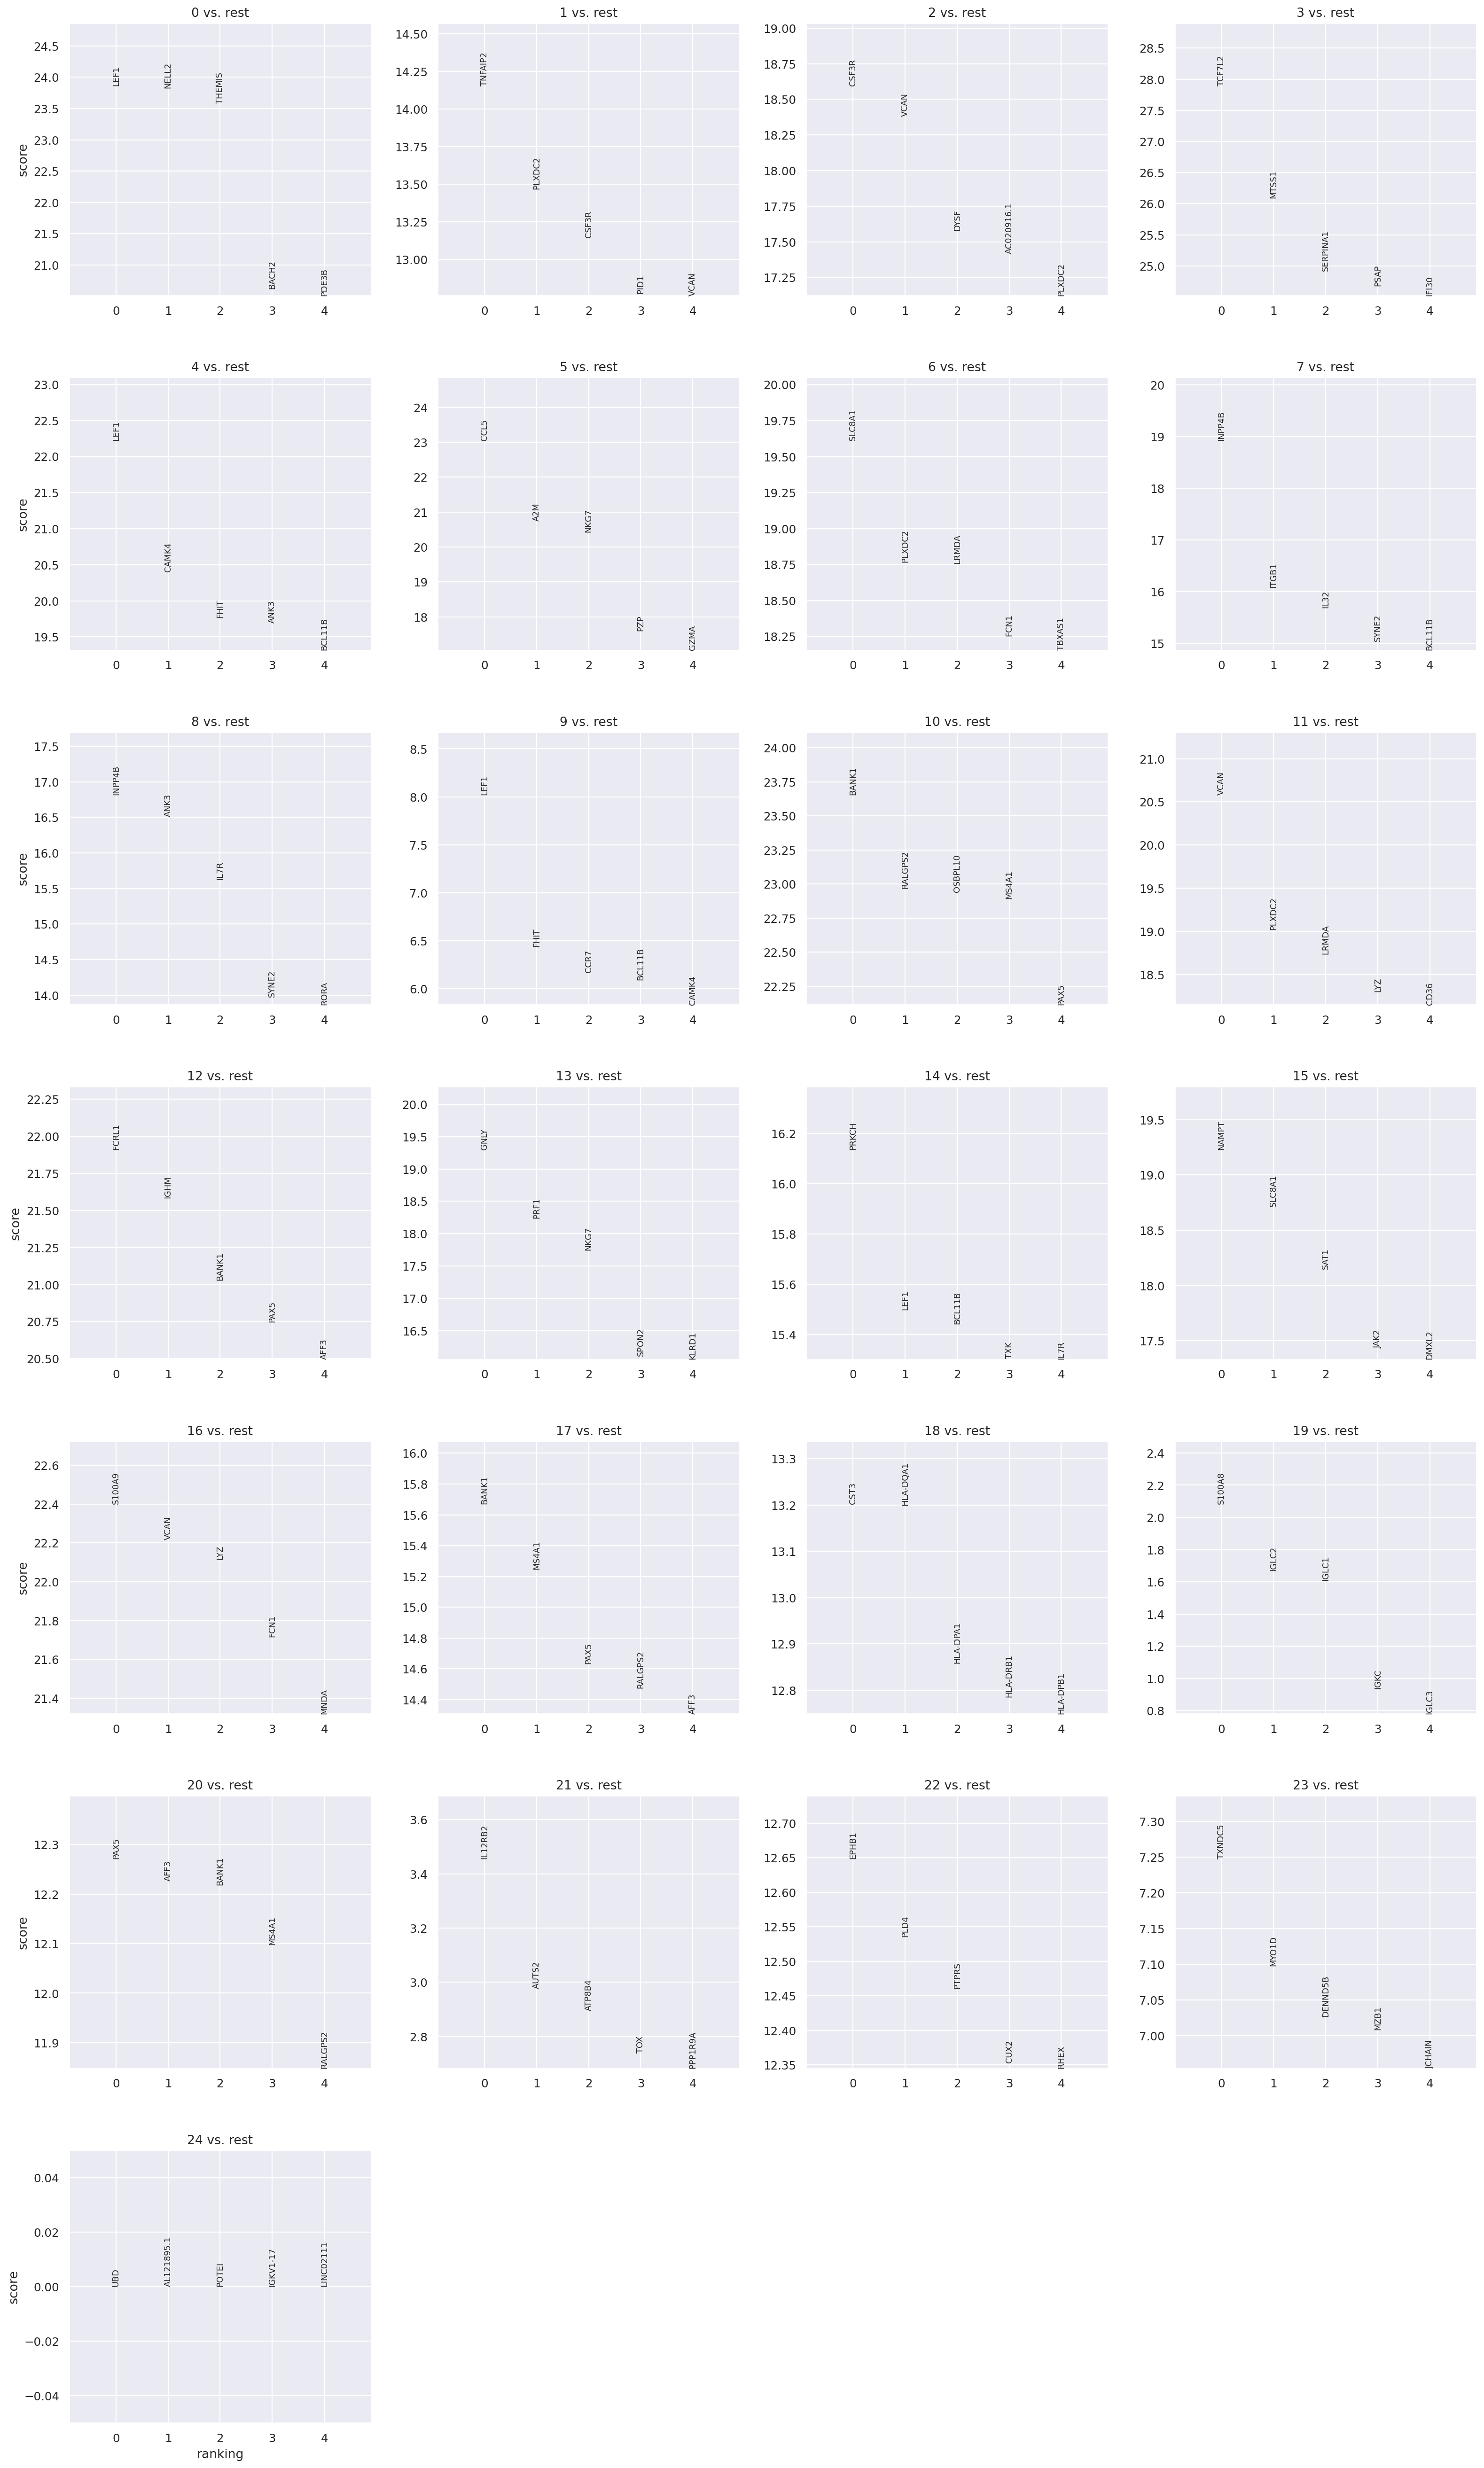

In [ ]:
# RNA modality AnnData (shared obs index)
rna_adata = mdata.mod["rna_subset"]


# Ensure the cluster assignment is present in the RNA AnnData obs (it references same obs by default)
rna_adata.obs["leiden_multivi"] = mdata.obs["leiden_multivi"].values


# Use scanpy to rank marker genes per cluster (Wilcoxon by default)
sc.tl.rank_genes_groups(rna_adata, groupby="leiden_multivi", method="wilcoxon")


# Show top markers for first few clusters
sc.pl.rank_genes_groups(rna_adata, n_genes=5, sharey=False)

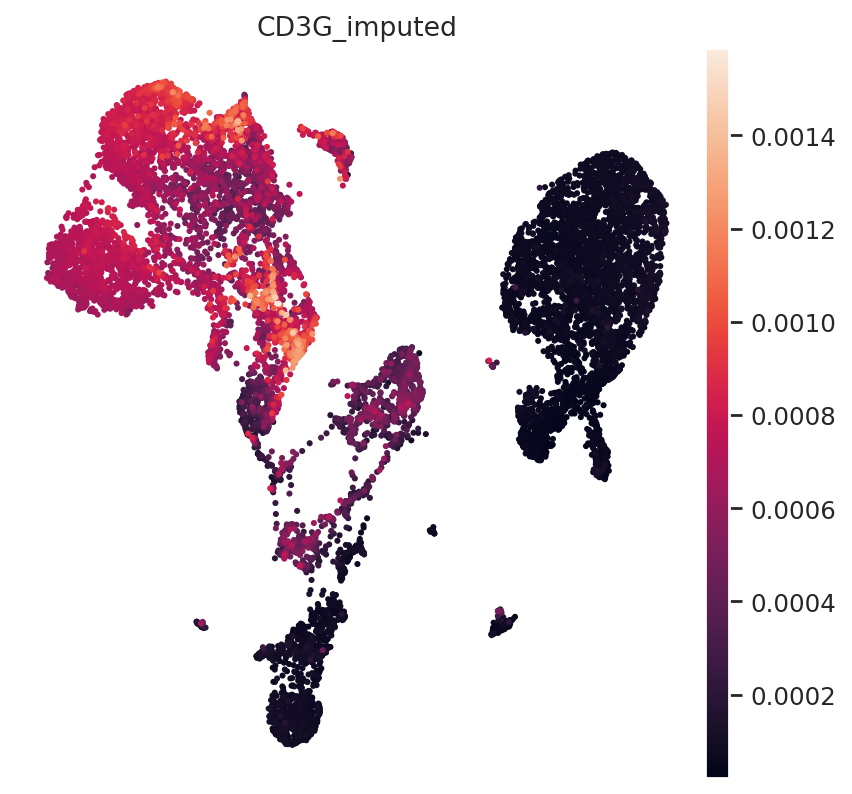

In [ ]:
# Get imputed (normalized) expression for all cells
imputed_expression = model.get_normalized_expression()


# Example: look for T-cell marker CD3G
import numpy as np


# Find index of gene name in RNA var (adjust if gene name casing differs)
gene = "CD3G"
try:
    gene_idx = np.where(mdata.mod["rna_subset"].var.index == gene)[0]
    if gene_idx.size == 0:
        raise ValueError(f"Gene {gene} not found in RNA var index; try a different marker from rna_adata.var.index[:50]")
    gene_idx = gene_idx[0]
    mdata.obs[f"{gene}_imputed"] = imputed_expression.iloc[:, gene_idx].values
    sc.pl.umap(mdata, color=f"{gene}_imputed", size=30)
except Exception as e:
    print(e)
    print("Try a gene from the RNA var index, e.g.", list(mdata.mod["rna_subset"].var.index[:20]))

In [ ]:
# Example save paths
model_dir = os.path.join(save_dir.name, "multivi_pbmc10k")
model.save(model_dir, overwrite=True)


# Save the MuData object
mdata.write(os.path.join(save_dir.name, "pbmc_multivi_results.h5mu"))
print("Saved model and MuData to:", save_dir.name)

Saved model and MuData to: /tmp/tmpotoo3gp2


/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/lib/python3.12/dist-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
!pip install streamlit scvi-tools muon scanpy matplotlib seaborn plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 138.4 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import scanpy as sc
import muon as mu
import scvi
import plotly.express as px
import pandas as pd
import numpy as np
import tempfile
import os
import requests

# ------------------ PAGE CONFIGURATION ------------------
st.set_page_config(
    page_title="Single-Cell Multi-Omics Integrator",
    page_icon="🧬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# ------------------ HEADER ------------------
st.title("🧬 Single-Cell Multi-Omics Integrator (MultiVI)")
st.markdown("""
This interactive tool allows you to **analyze and visualize integrated single-cell RNA + ATAC data**
using the **MultiVI model (from scvi-tools)**.
It is inspired by the [Cantini Lab (Institut Pasteur)](https://github.com/cantinilab) research on integrative genomics.
""")

# ------------------ SIDEBAR NAVIGATION ------------------
st.sidebar.title("🔍 Navigation")
page = st.sidebar.radio("Go to", ["About App", "Upload & Setup", "Train Model", "Visualization", "Marker Genes"])

# Temporary folder for data and models
temp_dir = tempfile.TemporaryDirectory()

# ------------------ ABOUT SECTION ------------------
if page == "About App":
    st.subheader("ℹ️ About this App")
    st.markdown("""
    **Single-Cell Multi-Omics Integrator** is a Streamlit web application designed to integrate
    single-cell RNA-seq and ATAC-seq data using the **MultiVI model** from the [scvi-tools library](https://scvi-tools.org/).

    ### 💡 What this App Does
    - Loads a demo PBMC 10k multiome dataset (or your uploaded dataset)
    - Trains a MultiVI model to integrate gene expression and chromatin accessibility
    - Projects the data into a shared latent space
    - Performs clustering (Leiden) and visualizes results using UMAP
    - Enables marker gene discovery and imputation visualization

    ### 🧭 How to Use
    1. Go to **Upload & Setup** to load the demo dataset or upload your `.h5mu` file.
    2. Move to **Train Model** to run MultiVI training (GPU recommended).
    3. Explore **Visualization** for UMAP and cluster plots.
    4. Use **Marker Genes** to inspect top genes per cluster.

    ### 🧑‍🔬 Built With
    - [scvi-tools](https://scvi-tools.org/)
    - [Streamlit](https://streamlit.io/)
    - [muon](https://muon.readthedocs.io/)
    - [scanpy](https://scanpy.readthedocs.io/)
    """)

# ------------------ UPLOAD & SETUP ------------------
elif page == "Upload & Setup":
    st.subheader("📁 Upload or Load Dataset")

    demo = st.checkbox("Use Demo PBMC Multiome Dataset", value=True)
    uploaded_file = st.file_uploader("Or upload your own .h5mu file", type=["h5mu"])

    if demo:
        with st.spinner("Downloading demo PBMC dataset..."):
            url = "https://figshare.com/ndownloader/files/54794234"
            data_path = os.path.join(temp_dir.name, "pbmc_10k_preprocessed.h5mu")
            r = requests.get(url)
            with open(data_path, "wb") as f:
                f.write(r.content)
            mdata = mu.read_h5mu(data_path)
        st.success("✅ Demo dataset loaded successfully!")
        st.write(mdata)
        st.session_state["mdata"] = mdata

    elif uploaded_file is not None:
        with st.spinner("Reading uploaded file..."):
            mdata = mu.read_h5mu(uploaded_file)
        st.success("✅ File uploaded successfully!")
        st.write(mdata)
        st.session_state["mdata"] = mdata

# ------------------ TRAIN MODEL ------------------
elif page == "Train Model":
    st.subheader("⚙️ Train MultiVI Model")

    if "mdata" not in st.session_state:
        st.warning("Please upload or load a dataset first under 'Upload & Setup'.")
    else:
        mdata = st.session_state["mdata"]
        scvi.model.MULTIVI.setup_mudata(
            mdata,
            modalities={
                "rna_layer": "rna_subset",
                "atac_layer": "atac_subset",
            },
        )

        n_genes = len(mdata.mod["rna_subset"].var)
        n_regions = len(mdata.mod["atac_subset"].var)
        model = scvi.model.MULTIVI(mdata, n_genes=n_genes, n_regions=n_regions)

        with st.spinner("Training MultiVI model... (this may take a few minutes)"):
            model.train(max_epochs=25)

        st.session_state["model"] = model
        st.success("✅ Model training complete!")

# ------------------ VISUALIZATION ------------------
elif page == "Visualization":
    st.subheader("📊 Visualize UMAP and Clusters")

    if "model" not in st.session_state:
        st.warning("Please train the model first.")
    else:
        mdata = st.session_state["mdata"]
        model = st.session_state["model"]

        latent_key = "X_multivi"
        mdata.obsm[latent_key] = model.get_latent_representation()

        sc.pp.neighbors(mdata, use_rep=latent_key)
        sc.tl.umap(mdata)
        sc.tl.leiden(mdata, resolution=1.0, key_added="leiden_multivi")

        embedding = pd.DataFrame(
            mdata.obsm["X_umap"], columns=["UMAP1", "UMAP2"], index=mdata.obs_names
        )
        embedding["Cluster"] = mdata.obs["leiden_multivi"]

        fig = px.scatter(
            embedding,
            x="UMAP1",
            y="UMAP2",
            color="Cluster",
            title="UMAP Visualization (Leiden Clusters)",
            color_discrete_sequence=px.colors.qualitative.Safe,
        )
        st.plotly_chart(fig, use_container_width=True)

# ------------------ MARKER GENES ------------------
elif page == "Marker Genes":
    st.subheader("🧠 Explore Marker Genes")

    if "mdata" not in st.session_state or "model" not in st.session_state:
        st.warning("Please complete the earlier steps first.")
    else:
        mdata = st.session_state["mdata"]
        rna = mdata.mod["rna_subset"]

        if "leiden_multivi" not in rna.obs:
            st.warning("Run 'Visualization' first to create clusters.")
        else:
            sc.tl.rank_genes_groups(rna, groupby="leiden_multivi", method="wilcoxon")

            result = rna.uns["rank_genes_groups"]
            groups = result["names"].dtype.names

            df = pd.DataFrame(
                {group + "_top_genes": result["names"][group][:5] for group in groups}
            )
            st.dataframe(df)

            gene = st.text_input("Enter gene to visualize (e.g. CD3G):")
            if gene:
                imputed = st.session_state["model"].get_normalized_expression()
                if gene in rna.var_names:
                    vals = imputed[gene].values
                    mdata.obs["imputed"] = vals
                    sc.pp.neighbors(mdata, use_rep="X_multivi")
                    sc.tl.umap(mdata)
                    fig2 = px.scatter(
                        x=mdata.obsm["X_umap"][:, 0],
                        y=mdata.obsm["X_umap"][:, 1],
                        color=mdata.obs["imputed"],
                        color_continuous_scale="Viridis",
                        labels={"color": f"{gene} (imputed)"},
                        title=f"Imputed Expression of {gene}",
                    )
                    st.plotly_chart(fig2, use_container_width=True)
                else:
                    st.warning("Gene not found in dataset.")


2025-10-09 09:02:04.310 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 09:02:04.313 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 09:02:04.963 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-09 09:02:04.964 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 09:02:04.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 09:02:04.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-09 09:02:04.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

In [ ]:
get_ipython().system('streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py')




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.124.162.0:8501

  Stopping...
  Stopping...
Exception ignored in: <module 'threading' from '/usr/lib/python3.12/threading.py'>
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1575, in _shutdown
    def _shutdown():
    
  File "/usr/local/lib/python3.12/dist-packages/streamlit/web/bootstrap.py", line 42, in signal_handler
    server.stop()
  File "/usr/local/lib/python3.12/dist-packages/streamlit/web/server/server.py", line 510, in stop
    self._runtime.stop()
  File "/usr/local/lib/python3.12/dist-packages/streamlit/runtime/runtime.py", line 329, in stop
    async_objs.eventloop.call_soon_threadsafe(stop_on_eventloop)
  File "/usr/lib/python3.12/asyncio/base_events.py", line 844, in call_soon_threadsafe
    self._check_closed()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 545, in 